In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
%matplotlib inline
from helpers import *
from datetime import datetime

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/"

with open("hyperParams.json") as f:
    instanceParams = json.load(f)

printFrequency = instanceParams["printFreq"]
batchSize = 1#instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

photoAlpha = instanceParams["photoParams"]["robustness"]
photoBeta = instanceParams["photoParams"]["scale"]
wei = instanceParams["smoothParams"]["weight"]

In [4]:
#gt = np.zeros((480, 854))
gt = mpimg.imread("../example_data/data/DAVIS/Annotations/480p/train/00023.png")[16:-16,11:-11]
# plt.imshow(gt, cmap='gray')

In [5]:
flow = np.zeros((448, 832, 2))

In [6]:
flow = np.expand_dims(flow, 0)
gt = np.expand_dims(np.expand_dims(gt, 0), -1)

In [7]:
flow = tf.cast(flow, tf.float32)
gt = tf.cast(gt, tf.float32)
flow = tf.Variable(flow)

In [8]:
img0 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00023.jpg"), channels=3, dtype=tf.uint8)
img1 = tf.image.decode_png(tf.read_file("../example_data/data/DAVIS/JPEGImages/480p/train/00024.jpg"), channels=3, dtype=tf.uint8)

rgb0 = tf.cast(img0, tf.float32) - [[[[0,0,0]]]]
rgb1 = tf.cast(img1, tf.float32) - [[[[0,0,0]]]]

In [9]:
rgb0 = rgb0[:,16:-16,11:-11,:]
rgb1 = rgb1[:,16:-16,11:-11,:]

In [17]:
lambdaTensor = tf.placeholder(tf.float32)
sLoss, _ = asymmetricSmoothLoss(flow, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
pLoss = photoLoss(flow, rgb0, rgb1, photoAlpha, 1)

tLoss = pLoss + lambdaTensor * sLoss

In [18]:
sGrad = tf.gradients(sLoss, flow)
pGrad = tf.gradients(pLoss, flow)
tGrad = tf.gradients(tLoss, flow)

In [19]:
momentum1 = 0.9
momentum2 = 0.999

def attach_SGD_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]
    
def attach_ADAM_Solver(loss):
    with tf.variable_scope(None,default_name="solver"):
        learningRate = tf.placeholder(tf.float32,shape=[])
        solver = tf.train.AdamOptimizer(learning_rate=learningRate , beta1=momentum1, beta2=momentum2)
        solver_op = solver.minimize(loss)
        return [solver, solver_op, learningRate]

In [20]:
itr = 2500
solver, solver_op, learningRateTensor = attach_ADAM_Solver(tLoss)

In [21]:
init = tf.global_variables_initializer()
sLosses = []
pLosses = []
sGrads = []
pGrads = []
tGrads = []
flows = []
start_time = None
print_freq = 10
with tf.Session() as sess:
    sess.run(init)
    for i in range(1, itr + 2):
        feed_dict = {
            learningRateTensor: 1,
            lambdaTensor: 200.0
        }
        _, p, s, f, pg, sg = sess.run([solver_op, pLoss, sLoss, flow, pGrad, sGrad], feed_dict = feed_dict)
        if i % print_freq == 1:
            print(i)
            pLosses.append(np.mean(p))
            sLosses.append(np.mean(s))
            flows.append(deepcopy(f[0]))
            print "Photo loss: %f" % float(pLosses[-1])
            print "Smooth loss: %f" % float(sLosses[-1])

            pGrads.append(np.median(np.abs(pg[0])))
            sGrads.append(np.median(np.abs(sg[0])))

1
Photo loss: 2944.343994
Smooth loss: 0.000004
11
Photo loss: 682.158997
Smooth loss: 3.595203
21
Photo loss: 482.266266
Smooth loss: 2.306892
31
Photo loss: 389.340454
Smooth loss: 1.842292
41
Photo loss: 347.247162
Smooth loss: 1.644021
51
Photo loss: 326.804504
Smooth loss: 1.557037
61
Photo loss: 316.498291
Smooth loss: 1.516541
71
Photo loss: 310.452667
Smooth loss: 1.497186
81
Photo loss: 307.492950
Smooth loss: 1.487109
91
Photo loss: 304.986877
Smooth loss: 1.482744
101
Photo loss: 302.997528
Smooth loss: 1.480397
111
Photo loss: 301.494995
Smooth loss: 1.478642
121
Photo loss: 300.630249
Smooth loss: 1.475853
131
Photo loss: 299.689636
Smooth loss: 1.474118
141
Photo loss: 299.242432
Smooth loss: 1.472918
151
Photo loss: 298.304810
Smooth loss: 1.472823
161
Photo loss: 298.024353
Smooth loss: 1.472113
171
Photo loss: 297.320984
Smooth loss: 1.472193
181
Photo loss: 296.700470
Smooth loss: 1.472190
191
Photo loss: 296.084930
Smooth loss: 1.471254
201
Photo loss: 296.004883
Smo

KeyboardInterrupt: 

max flow: 18.7491
flow range:
u = -8.147 .. 14.300
v = -14.064 .. 14.888


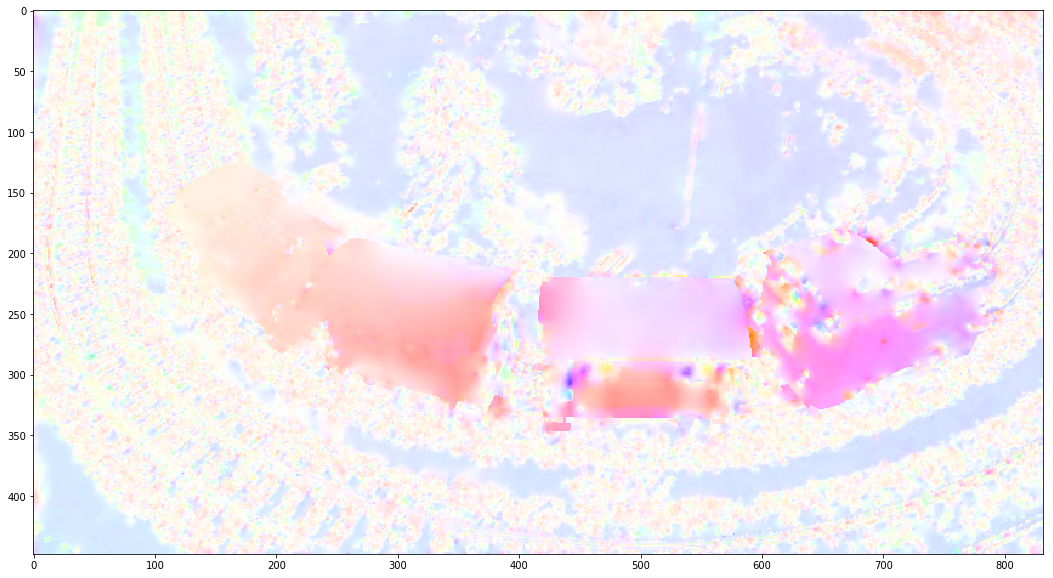

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(flow_to_image(flows[80]))

In [13]:
sLosses = np.array(sLosses)
pLosses = np.array(pLosses)
tLosses = pLosses + 1000 * sLosses

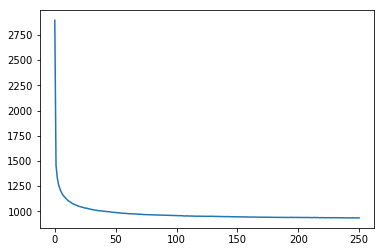

In [14]:
plt.plot(tLosses)

In [15]:
# np.save("train_sgd_lambda10k", tLosses)
# np.save("train_ADAM_lambda10k", tLosses)
np.save("train_sgd_lambda1k", tLosses)
# np.save("train_ADAM_lambda1k", tLosses)

In [68]:
pGrads = np.array(pGrads)
sGrads = 10000 * np.array(sGrads)

In [69]:
sGrads / pGrads

array([  0.       , 107.33774  ,  59.13647  ,  42.05841  ,  32.49049  ,
        25.13731  ,  19.964344 ,  16.335506 ,  14.002382 ,  12.775051 ,
        12.209009 ,  11.971276 ,  11.858102 ,  11.859723 ,  11.896732 ,
        11.9563265,  12.023793 ,  12.081886 ,  12.136457 ,  12.25059  ,
        12.323214 ,  12.434466 ,  12.475343 ,  12.677871 ,  12.888005 ,
        12.918086 ,  13.037241 ,  13.197304 ,  13.434447 ,  13.566756 ,
        13.812415 ,  14.007099 ,  14.191993 ,  14.495276 ,  14.821859 ,
        15.184865 ,  15.506054 ,  15.725957 ,  15.978711 ,  16.337547 ,
        16.65652  ,  17.00537  ,  17.373228 ,  17.666231 ,  17.886917 ,
        18.226782 ,  18.578886 ,  19.12712  ,  19.292059 ,  19.594963 ,
        19.808605 ,  20.0165   ,  20.607262 ,  20.88544  ,  21.19125  ,
        21.419193 ,  21.588207 ,  22.128168 ,  22.415813 ,  22.403196 ,
        22.630054 ,  23.122086 ,  23.598915 ,  23.868128 ,  23.956997 ,
        23.835884 ,  24.136497 ,  24.828857 ,  25.388256 ,  25.4

In [66]:
sGrads / pGrads

array([ 0.       , 78.85588  , 35.515846 , 18.769423 , 13.098962 ,
        9.030966 ,  6.332308 ,  4.597433 ,  3.4338439,  2.6921976,
        2.2149725,  1.9327761,  1.7623957,  1.6730822,  1.6253273,
        1.611851 ,  1.6121863,  1.6028745,  1.6070892,  1.6044111,
        1.6031506,  1.5978489,  1.58994  ,  1.5980084,  1.6148584,
        1.6379609,  1.6680874,  1.720877 ,  1.770113 ,  1.8328793,
        1.917575 ,  2.026617 ,  2.1806207,  2.3941865,  2.635737 ,
        2.8859017,  3.1403124,  3.4181592,  3.6453786,  3.8773096,
        4.104891 ,  4.3342404,  4.6141844,  4.9204164,  5.276886 ,
        5.6470556,  5.961747 ,  6.281844 ,  6.6720476,  7.157152 ,
        7.575507 ,  7.8292465,  8.102507 ,  8.446499 ,  8.911143 ,
        9.293349 ,  9.725517 ,  9.948705 , 10.236209 , 10.5177765,
       10.87695  , 11.425725 , 11.82251  , 12.131097 , 12.212995 ,
       12.685285 , 13.142603 , 13.780664 , 13.982604 , 14.119725 ,
       14.159096 , 14.440068 , 14.966305 , 15.749929 , 16.0681